In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cosmetics, chemicals... it's complicated

Whenever I want to try a new cosmetic item, it's so difficult to choose. It's actually more than difficult. It's sometimes scary because new items that I've never tried end up giving me skin trouble. We know the information we need is on the back of each product, but it's really hard to interpret those ingredient lists unless you're a chemist. You may be able to relate to this situation.

So instead of buying and hoping for the best, why don't we use data science to help us predict which products may be good fits for us? In this notebook, we are going to create a content-based recommendation system where the 'content' will be the chemical components of cosmetics. Specifically, we will process ingredient lists for 1472 cosmetics on Sephora via word embedding, then visualize ingredient similarity using a machine learning method called t-SNE and an interactive visualization library called Bokeh. Let's inspect our data first.

In [2]:
df=pd.read_csv("cosmetics.csv")
df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


In [3]:
df.shape

(1472, 11)

In [4]:
df.size

16192

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   Brand        1472 non-null   object 
 2   Name         1472 non-null   object 
 3   Price        1472 non-null   int64  
 4   Rank         1472 non-null   float64
 5   Ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


In [6]:
df.dtypes

Label           object
Brand           object
Name            object
Price            int64
Rank           float64
Ingredients     object
Combination      int64
Dry              int64
Normal           int64
Oily             int64
Sensitive        int64
dtype: object

In [7]:
df.Label.value_counts()

Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

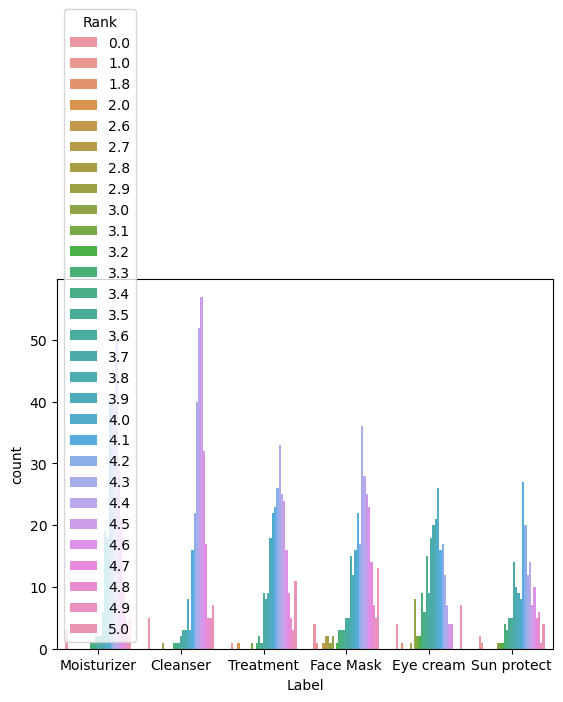

In [8]:
sns.countplot(df,x="Label",hue="Rank")

# 2. Focus on one product category and one skin type

There are six categories of product in our data (moisturizers, cleansers, face masks, eye creams, and sun protection) and there are five different skin types (combination, dry, normal, oily and sensitive). Because individuals have different product needs as well as different skin types, let's set up our workflow so its outputs (a t-SNE model and a visualization of that model) can be customized. For the example in this notebook, let's focus in on moisturizers for those with dry skin by filtering the data accordingly.

In [12]:
moisturizers=df[df["Label"]=="Moisturizer"]


In [13]:
moisturizers_dry=moisturizers[moisturizers["Dry"]==1]


In [11]:
moisturizers_dry =moisturizers_dry.reset_index(drop=True)
moisturizers

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
293,Moisturizer,LA MER,The Moisturizing Matte Lotion,270,3.9,"Water, Algae (Seaweed) Extract, Propanediol, S...",0,0,1,1,0
294,Moisturizer,HERBIVORE,Jasmine Green Tea Balancing Toner,39,4.2,"Jasminum Officinale (Jasmine) Flower Water, Ha...",1,0,0,1,1
295,Moisturizer,CLARINS,Super Restorative Night Age Spot Correcting Re...,136,4.5,"Water, Cetearyl Isononanoate, Dimethicone, Gly...",0,0,0,0,0
296,Moisturizer,KATE SOMERVILLE,Goat Milk Moisturizing Cream,65,4.1,"Water, Ethylhexyl Palmitate, Myristyl Myristat...",1,1,1,1,1


In [15]:
moisturizers.sort_values(by="Rank",ascending=False)
#moisturizers  according to their ranking

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
244,Moisturizer,LANEIGE,Water Bank Dual Layer Face Oil,38,5.0,"Water, Caprylic/Capric Triglyceride, Squalane,...",1,1,1,0,0
228,Moisturizer,DIOR,Capture Totale Multi-Perfection Creme Refill,140,5.0,Visit the Dior boutique,0,0,0,0,0
194,Moisturizer,CLINIQUE,Limited Edition Dramatically Different™ Moistu...,39,5.0,"Water, Dimethicone, Isododecane, Butylene Glyc...",1,0,0,1,0
177,Moisturizer,NURSE JAMIE,Tech Neck Prevention Kit,69,5.0,-Silicone Wrap: Creates a hydrating climate fo...,0,0,0,0,0
9,Moisturizer,LA MER,Little Miss Miracle Limited-Edition Crème de l...,325,5.0,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
261,Moisturizer,TATA HARPER,Repairative Moisturizer,110,3.4,*Ingredients from organic farming. **Clinical ...,0,1,0,0,0
98,Moisturizer,LA MER,The Moisturizing Cool Gel Cream,175,3.3,Visit the La Mer boutique,1,1,1,1,1
279,Moisturizer,CLINIQUE,Limited Edition Dramatically Different Moistur...,39,0.0,"Water, Mineral Oil/Paraffinum Liquidum/Huile M...",1,1,0,0,0
97,Moisturizer,LA MER,The Concentrate Mini,190,0.0,"Cyclopentasiloxane, Algae (Seaweed) Extract, G...",0,0,0,0,0


In [16]:
sun=df[df["Label"]=="Sun protect"]
sun

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
1302,Sun protect,LAURA MERCIER,Tinted Moisturizer Broad Spectrum SPF 20,45,4.4,Visit the Laura Mercier boutique,0,0,0,0,0
1303,Sun protect,LAURA MERCIER,Tinted Moisturizer Broad Spectrum SPF 20 - Oil...,45,4.3,Visit the Laura Mercier boutique,0,0,0,0,0
1304,Sun protect,SHISEIDO,Urban Environment Oil-Free UV Protector Broad ...,34,4.5,"Water, Dimethicone, Isododecane, Sd Alcohol 40...",1,0,1,1,0
1305,Sun protect,NARS,Pure Radiant Tinted Moisturizer Broad Spectrum...,45,4.4,Visit the NARS boutique,0,0,0,0,0
1306,Sun protect,SUPERGOOP!,Unseen Sunscreen Broad Spectrum SPF 40,32,4.5,"Isododecane, Dimethicone Crosspolymer, Dimethi...",1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1467,Sun protect,KORRES,Yoghurt Nourishing Fluid Veil Face Sunscreen B...,35,3.9,"Water, Alcohol Denat., Potassium Cetyl Phospha...",1,1,1,1,1
1468,Sun protect,KATE SOMERVILLE,Daily Deflector™ Waterlight Broad Spectrum SPF...,48,3.6,"Water, Isododecane, Dimethicone, Butyloctyl Sa...",0,0,0,0,0
1469,Sun protect,VITA LIBERATA,Self Tan Dry Oil SPF 50,54,3.5,"Water, Dihydroxyacetone, Glycerin, Sclerocarya...",0,0,0,0,0
1470,Sun protect,ST. TROPEZ TANNING ESSENTIALS,Pro Light Self Tan Bronzing Mist,20,1.0,"Water, Dihydroxyacetone, Propylene Glycol, PPG...",0,0,0,0,0


In [17]:
sun.reset_index(drop=True)

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Sun protect,LAURA MERCIER,Tinted Moisturizer Broad Spectrum SPF 20,45,4.4,Visit the Laura Mercier boutique,0,0,0,0,0
1,Sun protect,LAURA MERCIER,Tinted Moisturizer Broad Spectrum SPF 20 - Oil...,45,4.3,Visit the Laura Mercier boutique,0,0,0,0,0
2,Sun protect,SHISEIDO,Urban Environment Oil-Free UV Protector Broad ...,34,4.5,"Water, Dimethicone, Isododecane, Sd Alcohol 40...",1,0,1,1,0
3,Sun protect,NARS,Pure Radiant Tinted Moisturizer Broad Spectrum...,45,4.4,Visit the NARS boutique,0,0,0,0,0
4,Sun protect,SUPERGOOP!,Unseen Sunscreen Broad Spectrum SPF 40,32,4.5,"Isododecane, Dimethicone Crosspolymer, Dimethi...",1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
165,Sun protect,KORRES,Yoghurt Nourishing Fluid Veil Face Sunscreen B...,35,3.9,"Water, Alcohol Denat., Potassium Cetyl Phospha...",1,1,1,1,1
166,Sun protect,KATE SOMERVILLE,Daily Deflector™ Waterlight Broad Spectrum SPF...,48,3.6,"Water, Isododecane, Dimethicone, Butyloctyl Sa...",0,0,0,0,0
167,Sun protect,VITA LIBERATA,Self Tan Dry Oil SPF 50,54,3.5,"Water, Dihydroxyacetone, Glycerin, Sclerocarya...",0,0,0,0,0
168,Sun protect,ST. TROPEZ TANNING ESSENTIALS,Pro Light Self Tan Bronzing Mist,20,1.0,"Water, Dihydroxyacetone, Propylene Glycol, PPG...",0,0,0,0,0


In [18]:
cleanser=df[df["Label"]=="Cleanser"]
cleanser.reset_index(drop=True)

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Cleanser,DRUNK ELEPHANT,T.L.C. Sukari Babyfacial™,80,4.5,"Water, Glycolic Acid, Hydroxyethyl Acrylate/So...",1,1,1,1,0
1,Cleanser,DRUNK ELEPHANT,T.L.C. Framboos™ Glycolic Night Serum,90,4.3,"Water, Glycolic Acid, Butylene Glycol, Glyceri...",1,1,1,1,0
2,Cleanser,FRESH,Soy Face Cleanser,38,4.4,"Water, Coco-Glucoside, Glycerin, Butylene Glyc...",0,0,0,0,0
3,Cleanser,FARMACY,Green Clean Makeup Meltaway Cleansing Balm wit...,34,4.6,"Cetyl Ethylhexanoate, Caprylic/Capric Triglyce...",1,1,1,1,1
4,Cleanser,PHILOSOPHY,Purity Made Simple Cleanser,24,4.5,"Water, Sodium Lauroamphoacetate, Sodium Tridec...",1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
276,Cleanser,FENTY BEAUTY BY RIHANNA,Invisimatte Blotting Paper,16,3.9,Visit the FENTY BEAUTY by Rihanna boutique,0,0,0,0,0
277,Cleanser,CLINIQUE,Facial Soap with Dish,15,4.4,"Sodium Palmate/Cocoate Or/Ou Palm Kernelate , ...",0,0,0,0,0
278,Cleanser,ALGENIST,Hydrating Essence Toner,25,4.4,"Water, Butylene Glycol, Sodium PCA, Hamamelis ...",0,0,0,0,0
279,Cleanser,REN CLEAN SKINCARE,Micro Polish Cleanser,32,4.5,Citrus Aurantium Bergamia (Bergamot) Leaf Extr...,0,0,0,0,0


<Axes: xlabel='Price', ylabel='Rank'>

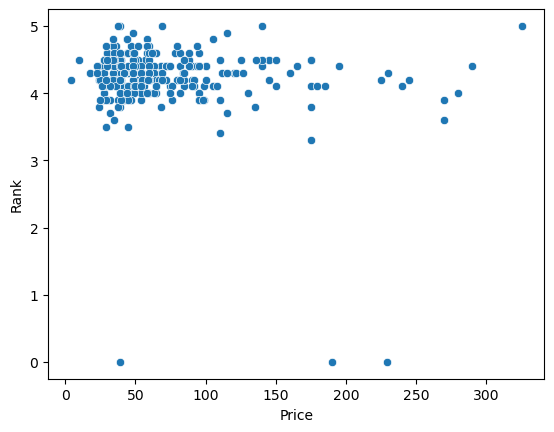

In [19]:
sns.scatterplot(moisturizers,x="Price",y="Rank")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 [Text(0, 0, 'LA MER'),
  Text(1, 0, 'SK-II'),
  Text(2, 0, 'DRUNK ELEPHANT'),
  Text(3, 0, 'IT COSMETICS'),
  Text(4, 0, 'TATCHA'),
  Text(5, 0, "KIEHL'S SINCE 1851"),
  Text(6, 0, 'FRESH'),
  Text(7, 0, 'BELIF'),
  Text(8, 0, 'SUNDAY RILEY'),
  Text(9, 0, 'FARMACY'),
  Text(10, 0, 'FIRST AID BEAUTY'),
  Text(11, 0, 'CLINIQUE'),
  Text(12, 0, 'BAREMINERALS'),
  Text(13, 0, 'SHISEIDO'),
  Text(14, 0, 'CHARLOTTE TILBURY'),
  Text(15, 0, 'ORIGINS'),
  Text(16, 0, 'OLEHENRIKSEN'),
  Text(17, 0, 'JOSIE MARAN'),
  Text(18, 0, 'FARSÁLI'),
  Text(19, 0, 'LANEIGE'),
  Text(20, 0, 'DR. JART+'),
  Text(21, 0, 'GLOW RECIPE'),
  Text(22, 0, 'HERBIVORE'),
  Text(23, 0, 'TARTE'),
  Text(24, 0, 'CAUDALIE'),
  Text(25, 0

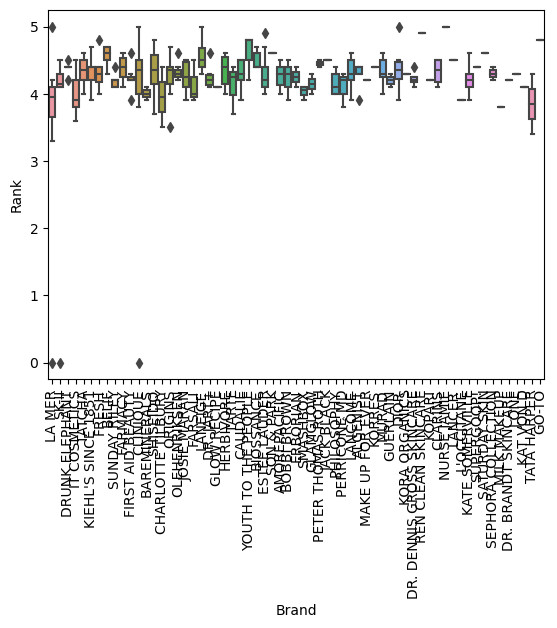

In [22]:
sns.boxplot(moisturizers,x="Brand",y="Rank")
plt.xticks(rotation=90)

<Axes: xlabel='Price', ylabel='Rank'>

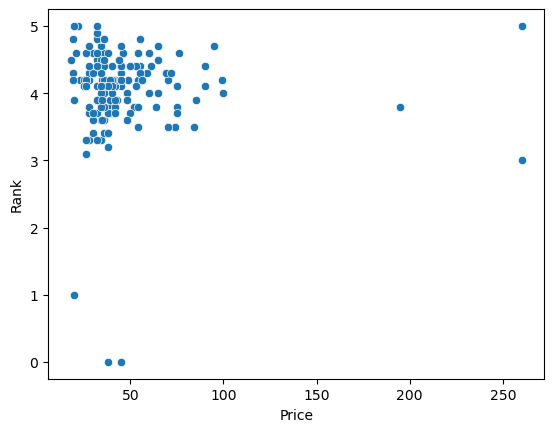

In [24]:
sns.scatterplot(sun,x="Price",y="Rank")
#most of the sunscreens with good ranking comes in between the price range of 30 and 100

<Axes: xlabel='Price', ylabel='Rank'>

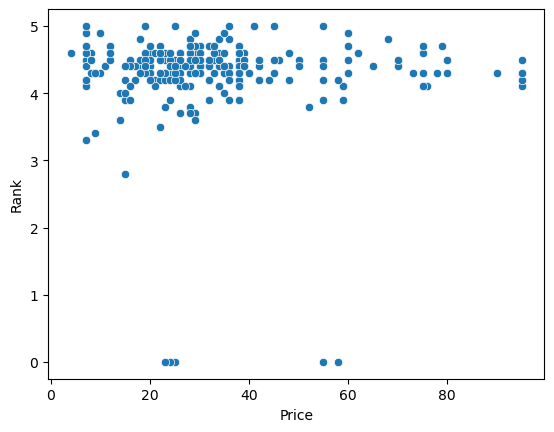

In [25]:
sns.scatterplot(cleanser,x="Price",y="Rank")

<Axes: xlabel='Price', ylabel='Rank'>

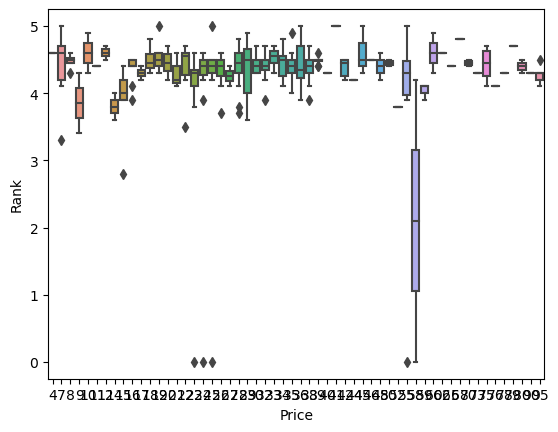

In [26]:
sns.boxplot(cleanser,x="Price",y="Rank")